In [17]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
)
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

In [18]:
train_df = pd.read_csv("../dataset/train_df_v2.csv")
test_df  = pd.read_csv("../dataset/test_df_v2.csv")

dupes = train_df.merge(
    test_df[['parent_asin', 'user_id']],
    on=['parent_asin', 'user_id'],
    how='inner'
)[['parent_asin', 'user_id']]

train_df = train_df.merge(dupes, on=['parent_asin', 'user_id'], how='left', indicator=True)
train_df = train_df[train_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [19]:
X_train = train_df.drop(columns=['exists', 'parent_asin', 'user_id'])
y_train = train_df['exists']

X_test  = test_df.drop(columns=['exists', 'parent_asin', 'user_id'])
y_test  = test_df['exists']

In [20]:
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    test_size=0.7,
    shuffle=True,
    stratify=y_train
)

param_dist = {
    "n_estimators": randint(300, 700),
    "max_depth": randint(12, 30),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0, 5)
}

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_sample, y_sample)
best = search.best_estimator_
best.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7599443886861021), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.23332831606807714), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.20475110376829186), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=26, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=663, n_jobs=None,
              num_parallel_tree=None, ...)

In [21]:
y_prob = best.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01, 0.99, 99)
best_th = 0.5
best_f1 = 0

for th in thresholds:
    preds = (y_prob >= th).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

print(f"Melhor threshold = {best_th:.3f}")
print(f"Melhor F1 = {best_f1:.4f}")

Melhor threshold = 0.010
Melhor F1 = 0.0766


In [22]:
y_pred = (y_prob >= best_th).astype(int)

accuracy  = accuracy_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)

print(f"Accuracy : {accuracy:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")


Accuracy : 0.5194
F1-score : 0.0766
Precision: 0.9748
Recall   : 0.0399


In [23]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC/ROC: {roc_auc:.4f}")

AUC/ROC: 0.6108


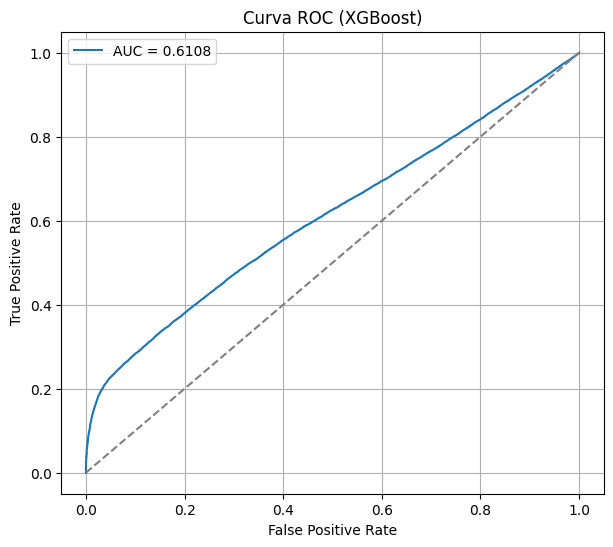

In [24]:
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (XGBoost)")
plt.legend()
plt.grid(True)